# EDAN95 - Applied Machine Learning
### LTH Fall 2019

# Lab 3
### David Larsson & Jonas Lundgren

## Collecting a Dataset

Code from https://github.com/pnugues/edan95.

In [1]:
import os
import random
import shutil

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image, display

from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3
from keras.preprocessing import image

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from mlxtend.plotting import plot_confusion_matrix

%matplotlib inline  

Using TensorFlow backend.


In [2]:
# To create the same dataset
random.seed(0)

original_dataset_dir = "flowers-recognition/flowers"
dataset = "flowers-recognition/flowers_split"

train_dir = os.path.join(dataset, 'train')
validation_dir = os.path.join(dataset, 'validation')
test_dir = os.path.join(dataset, 'test')

categories = os.listdir(original_dataset_dir)
categories = [category for category in categories if not category.startswith('.')]
print('Image types:', categories)
data_folders = [os.path.join(original_dataset_dir, category) for category in categories]

pairs = []
for folder, category in zip(data_folders, categories):
    images = os.listdir(folder)
    images = [image for image in images if not image.startswith('.')]
    pairs.extend([(image, category) for image in images])
    
random.shuffle(pairs)
img_nbr = len(pairs)
train_images = pairs[0:int(0.6 * img_nbr)]
val_images = pairs[int(0.6 * img_nbr):int(0.8 * img_nbr)]
test_images = pairs[int(0.8 * img_nbr):]

# print(train_images)
print(len(train_images))
print(len(val_images))
print(len(test_images))


for image, label in train_images:
    src = os.path.join(original_dataset_dir, label, image)
    dst = os.path.join(train_dir, label, image)
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)

for image, label in val_images:
    src = os.path.join(original_dataset_dir, label, image)
    dst = os.path.join(validation_dir, label, image)
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)

for image, label in test_images:
    src = os.path.join(original_dataset_dir, label, image)
    dst = os.path.join(test_dir, label, image)
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)

Image types: ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower']
2595
865
866


## Building a Simple Convolutional Neural Network

Chceck some random flowers

daisy


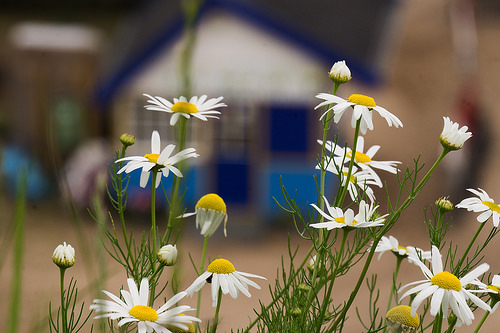

dandelion


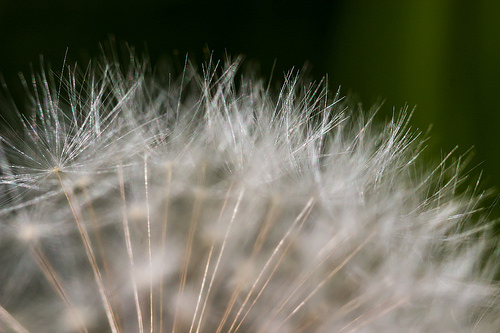

sunflower


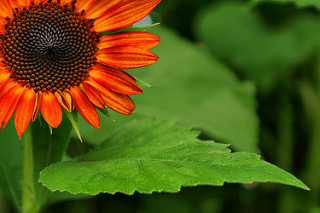

tulip


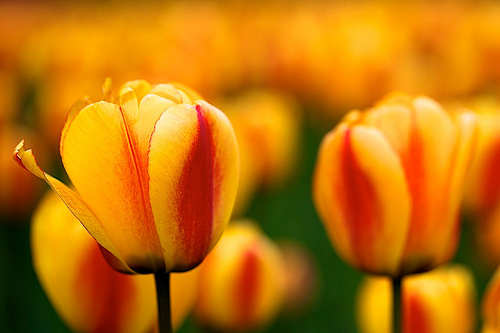

daisy


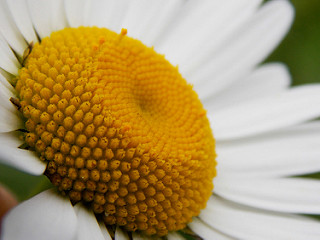

In [3]:
num_flowers = 5
random_flowers_idx = np.random.randint(0, len(train_images), num_flowers)
random_flowers = [train_images[i] for i in random_flowers_idx]

for image, label in random_flowers:
    src = os.path.join(train_dir, label, image)
    print(label)
    display(Image(filename=src))
    #im = Image.open(src)
    #im.show()


### 1.1 

Mode 1 corresponing to  Chollet, Deep Learning with Python, Listing 5.5

In [4]:
model = models.Sequential()
model.add(layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu',
                        input_shape = (150, 150, 3)))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(5, activation = 'softmax'))

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

In [6]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.RMSprop(lr = 1e-4),
              metrics = ['acc'])

In [7]:
train_datagen = ImageDataGenerator(rescale = 1. / 255)
val_datagen = ImageDataGenerator(rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)

Had to specify `classes` since a .ipynb_checkpoints file was created in the folder with images.

In [8]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (150,150),
                                                    batch_size = 20,
                                                    classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                                    class_mode = 'categorical')
validation_generator = val_datagen.flow_from_directory(validation_dir,
                                                       target_size = (150,150),
                                                       batch_size = 20,
                                                       classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                                       class_mode = 'categorical')
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  shuffle = False,
                                                  target_size = (150,150),
                                                  batch_size = 20,
                                                  classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                                  class_mode = 'categorical')

Found 2758 images belonging to 5 classes.
Found 865 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


Parameter to either retrain all models or load previously trained model weights.

In [9]:
retrain_model = True

In [10]:
if retrain_model:
    history = model.fit_generator(train_generator,
                                  steps_per_epoch = 129,
                                  epochs = 30, 
                                  validation_data = validation_generator,
                                  validation_steps = 43)

Epoch 1/30
129/129 [==============================] - 100s 778ms/step - loss: 1.3549 - acc: 0.4119 - val_loss: 1.0985 - val_acc: 0.4814
Epoch 2/30
129/129 [==============================] - 103s 799ms/step - loss: 1.1251 - acc: 0.5419 - val_loss: 1.6571 - val_acc: 0.5278
Epoch 3/30
129/129 [==============================] - 103s 797ms/step - loss: 1.0387 - acc: 0.5822 - val_loss: 1.5639 - val_acc: 0.5030
Epoch 4/30
129/129 [==============================] - 100s 772ms/step - loss: 0.9888 - acc: 0.6055 - val_loss: 0.9460 - val_acc: 0.5964
Epoch 5/30
129/129 [==============================] - 100s 776ms/step - loss: 0.9102 - acc: 0.6451 - val_loss: 0.9948 - val_acc: 0.6225
Epoch 6/30
129/129 [==============================] - 102s 790ms/step - loss: 0.8861 - acc: 0.6510 - val_loss: 1.4129 - val_acc: 0.5550
Epoch 7/30
129/129 [==============================] - 99s 771ms/step - loss: 0.8340 - acc: 0.6815 - val_loss: 0.9582 - val_acc: 0.6272
Epoch 8/30
129/129 [=============================

Here either the weights are saved or the weights of previously trained model is loaded into the model.

In [11]:
if retrain_model:
    model.save_weights('model_1_lab3.model')
else:
    model.load_weights('model_1_lab3.model')

Plotting the training process.

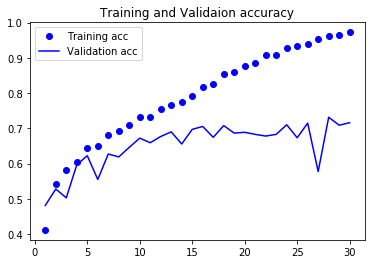

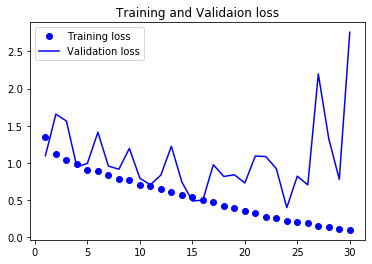

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validaion accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validaion loss')
plt.legend()

plt.show()

### 1.2

In [13]:
y_hat = model.predict_generator(test_generator)
y_pred = np.argmax(y_hat, axis=1)
y = test_generator.classes

In [14]:
print('Accuracy :', accuracy_score(y,y_pred))
print('Confusion Matrix :\n', confusion_matrix(y, y_pred))

Accuracy : 0.6774566473988439
Confusion Matrix :
 [[161  19  11   7  30]
 [ 20 113  10   9  10]
 [  8  13  95  53  17]
 [  4  15  27  97   6]
 [  9   2   6   3 120]]


A nicer looking confusion matrix for the report.

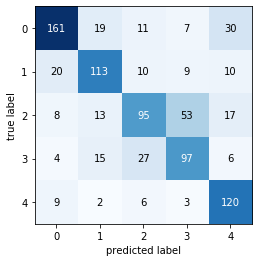

In [15]:
cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm);

### 1.3

This is my improved model. Added 1 more layer and dropout for last layer.

In [16]:
model2 = models.Sequential()
model2.add(layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu',
                        input_shape = (150, 150, 3)))
model2.add(layers.MaxPool2D(pool_size = (2, 2)))
model2.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model2.add(layers.MaxPool2D(pool_size = (2, 2)))
model2.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model2.add(layers.MaxPool2D(pool_size = (2, 2)))
model2.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model2.add(layers.MaxPool2D(pool_size = (2, 2)))
model2.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model2.add(layers.MaxPool2D(pool_size = (2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(512, activation = 'relu'))
model2.add(layers.Dense(5, activation = 'softmax'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

Using Adam as optimizer.

In [17]:
model2.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.adam(lr = 1e-4),
              metrics = ['acc'])

In [18]:
if retrain_model:
    history = model2.fit_generator(train_generator,
                                  steps_per_epoch = 129,
                                  epochs = 30, 
                                  validation_data = validation_generator,
                                  validation_steps = 43)

Epoch 1/30
129/129 [==============================] - 98s 756ms/step - loss: 1.5477 - acc: 0.2859 - val_loss: 1.3090 - val_acc: 0.4326
Epoch 2/30
129/129 [==============================] - 101s 783ms/step - loss: 1.2579 - acc: 0.4325 - val_loss: 0.9780 - val_acc: 0.4627
Epoch 3/30
129/129 [==============================] - 98s 757ms/step - loss: 1.1854 - acc: 0.4783 - val_loss: 1.1979 - val_acc: 0.4840
Epoch 4/30
129/129 [==============================] - 98s 758ms/step - loss: 1.1273 - acc: 0.5198 - val_loss: 1.2914 - val_acc: 0.4769
Epoch 5/30
129/129 [==============================] - 101s 784ms/step - loss: 1.0600 - acc: 0.5621 - val_loss: 1.3399 - val_acc: 0.5882
Epoch 6/30
129/129 [==============================] - 100s 778ms/step - loss: 1.0107 - acc: 0.5717 - val_loss: 1.0487 - val_acc: 0.5680
Epoch 7/30
129/129 [==============================] - 100s 776ms/step - loss: 0.9797 - acc: 0.6055 - val_loss: 1.0498 - val_acc: 0.5834
Epoch 8/30
129/129 [==============================]

In [19]:
if retrain_model:
    model2.save_weights('model_2_lab3.model')
else:
    model2.load_weights('model_2_lab3.model')

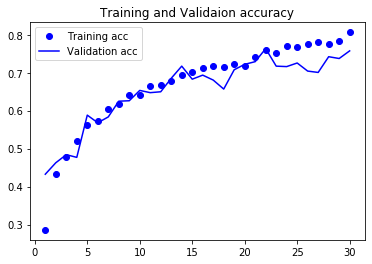

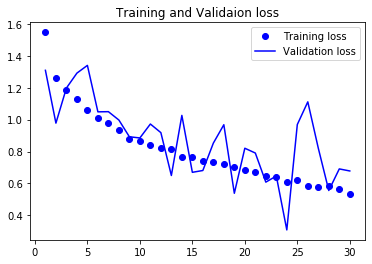

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validaion accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validaion loss')
plt.legend()

plt.show()

In [21]:
y_hat = model2.predict_generator(test_generator)
y_pred = np.argmax(y_hat, axis=1)
y = test_generator.classes

In [22]:
print('Accuracy :', accuracy_score(y,y_pred))
print('Confusion Matrix :\n', confusion_matrix(y, y_pred))

Accuracy : 0.7294797687861272
Confusion Matrix :
 [[166  15  14  13  20]
 [  9 123  10   9  11]
 [  4  10 131  29  12]
 [  7  10  42  83   7]
 [  4   3   4   1 128]]


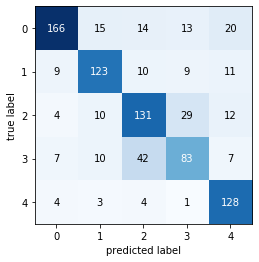

In [23]:
cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm);

### 2.1 Using Image Augmentation

In [24]:
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

Example of how the data augmentation looks.

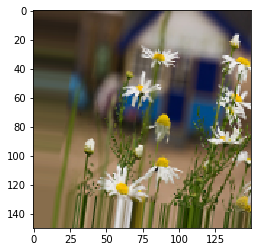

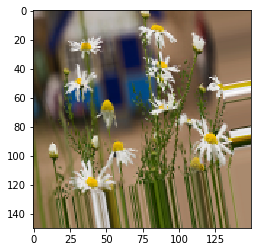

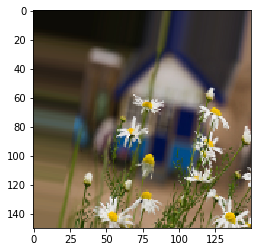

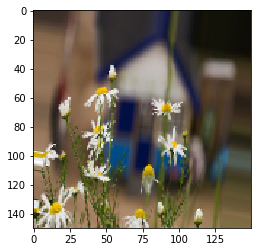

In [26]:
from keras.preprocessing import image

jpg, label = random_flowers[0]
img_path = os.path.join(train_dir, label, jpg)
img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

for i, batch in zip(range(4), datagen.flow(x, batch_size = 1)):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
                    
plt.show()

In [27]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,)


val_datagen = ImageDataGenerator(rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [28]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (150,150),
                                                    batch_size = 20,
                                                    classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                                    class_mode = 'categorical')
validation_generator = val_datagen.flow_from_directory(validation_dir,
                                                       target_size = (150,150),
                                                       batch_size = 20,
                                                       classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                                       class_mode = 'categorical')
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  shuffle = False,
                                                  target_size = (150,150),
                                                  batch_size = 20,
                                                  classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                                  class_mode = 'categorical')

Found 2758 images belonging to 5 classes.
Found 865 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


In [29]:
model3 = models.Sequential()
model3.add(layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu',
                        input_shape = (150, 150, 3)))
model3.add(layers.MaxPool2D(pool_size = (2, 2)))
model3.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model3.add(layers.MaxPool2D(pool_size = (2, 2)))
model3.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model3.add(layers.MaxPool2D(pool_size = (2, 2)))
model3.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model3.add(layers.MaxPool2D(pool_size = (2, 2)))
model3.add(layers.Flatten())
model3.add(layers.Dense(512, activation = 'relu'))
model3.add(layers.Dense(5, activation = 'softmax'))
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 15, 15, 128)      

In [30]:
model3.compile(loss = 'categorical_crossentropy',
               optimizer = optimizers.RMSprop(lr = 1e-4),
               metrics = ['acc'])

In [31]:
if retrain_model:
    history = model3.fit_generator(train_generator,
                                  steps_per_epoch = 129,
                                  epochs = 30, 
                                  validation_data = validation_generator,
                                  validation_steps = 43)

Epoch 1/30
129/129 [==============================] - 109s 841ms/step - loss: 1.3907 - acc: 0.3860 - val_loss: 1.3413 - val_acc: 0.3512
Epoch 2/30
129/129 [==============================] - 108s 834ms/step - loss: 1.2055 - acc: 0.4922 - val_loss: 1.6196 - val_acc: 0.4899
Epoch 3/30
129/129 [==============================] - 110s 850ms/step - loss: 1.1310 - acc: 0.5244 - val_loss: 1.1593 - val_acc: 0.5467
Epoch 4/30
129/129 [==============================] - 110s 853ms/step - loss: 1.0764 - acc: 0.5721 - val_loss: 1.0678 - val_acc: 0.6047
Epoch 5/30
129/129 [==============================] - 109s 845ms/step - loss: 1.0379 - acc: 0.5764 - val_loss: 1.0595 - val_acc: 0.5893
Epoch 6/30
129/129 [==============================] - 109s 847ms/step - loss: 1.0123 - acc: 0.6009 - val_loss: 1.3341 - val_acc: 0.5716
Epoch 7/30
129/129 [==============================] - 109s 842ms/step - loss: 0.9775 - acc: 0.6067 - val_loss: 1.1556 - val_acc: 0.6201
Epoch 8/30
129/129 [============================

In [32]:
if retrain_model:
    model3.save_weights('model_3_lab3.model')
else:
    model3.load_weights('model_3_lab3.model')

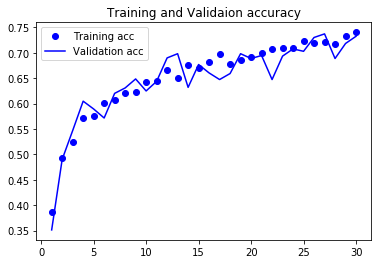

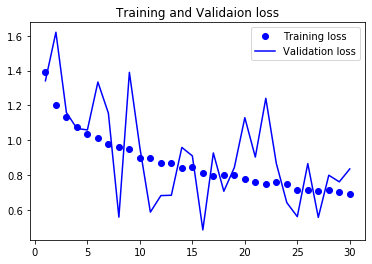

In [33]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validaion accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validaion loss')
plt.legend()

plt.show()

In [34]:
y_hat = model3.predict_generator(test_generator)
y_pred = np.argmax(y_hat, axis=1)
y = test_generator.classes

In [35]:
print('Accuracy :', accuracy_score(y,y_pred))
print('Confusion Matrix :\n', confusion_matrix(y, y_pred))

Accuracy : 0.7352601156069364
Confusion Matrix :
 [[202   2   3   7  14]
 [ 22 105   7  16  12]
 [ 12   4 102  54  14]
 [ 16   5  17 105   6]
 [ 11   0   5   2 122]]


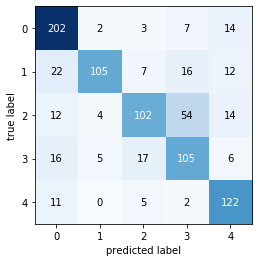

In [36]:
cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm);

## 3.1 Using a Pretrained Convolutional Base

From Chollet, Listing 5.11

In [37]:
conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))

In [38]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [39]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 3, 3, 2048))
    labels = np.zeros(shape=(sample_count, 5))
    generator = datagen.flow_from_directory(directory,
                                            target_size = (150,150),
                                            batch_size = 20,
                                            classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                            class_mode = 'categorical')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [40]:
train_features, train_labels = extract_features(train_dir, 2740)
validation_features, validation_labels = extract_features(validation_dir, 860)
test_features, test_labels = extract_features(test_dir, 860)

Found 2758 images belonging to 5 classes.
Found 865 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


In [41]:
train_features = train_features.reshape(2740, -1)
validation_features = validation_features.reshape(860, -1)
test_features = test_features.reshape(860, -1)

A MPL to feed the output from the convolutional bases into.

In [42]:
model4 = models.Sequential()
model4.add(layers.Dense(512, activation = 'relu', input_dim = 3*3*2048))
model4.add(layers.Dense(5, activation = 'softmax'))

model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               9437696   
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 2565      
Total params: 9,440,261
Trainable params: 9,440,261
Non-trainable params: 0
_________________________________________________________________


In [43]:
model4.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

history = model4.fit(train_features, 
                     train_labels, epochs = 30,
                     batch_size = 20,
                     validation_data = (validation_features, validation_labels))

Train on 2740 samples, validate on 860 samples
Epoch 1/30
2740/2740 [==============================] - 15s 5ms/step - loss: 7.4998 - accuracy: 0.6288 - val_loss: 3.8570 - val_accuracy: 0.5674
Epoch 2/30
2740/2740 [==============================] - 15s 5ms/step - loss: 1.7055 - accuracy: 0.7464 - val_loss: 1.7118 - val_accuracy: 0.7395
Epoch 3/30
2740/2740 [==============================] - 15s 5ms/step - loss: 1.0944 - accuracy: 0.8109 - val_loss: 3.9127 - val_accuracy: 0.6291
Epoch 4/30
2740/2740 [==============================] - 15s 5ms/step - loss: 0.6843 - accuracy: 0.8606 - val_loss: 1.0731 - val_accuracy: 0.7872
Epoch 5/30
2740/2740 [==============================] - 15s 5ms/step - loss: 0.4153 - accuracy: 0.9011 - val_loss: 0.9597 - val_accuracy: 0.8105
Epoch 6/30
2740/2740 [==============================] - 15s 5ms/step - loss: 0.3923 - accuracy: 0.9150 - val_loss: 1.6505 - val_accuracy: 0.7756
Epoch 7/30
2740/2740 [==============================] - 15s 5ms/step - loss: 0.3297

In [44]:
if retrain_model:
    model4.save_weights('model_4_lab3.model')
else:
    model4.load_weights('model_4_lab3.model')

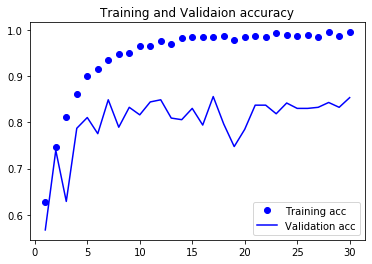

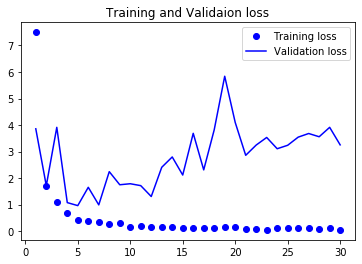

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validaion accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validaion loss')
plt.legend()

plt.show()

In [46]:
y_hat = model4.predict(test_features)
y_pred = np.argmax(y_hat, axis = 1)
y = np.argmax(test_labels, axis = 1)

In [47]:
print('Accuracy :', accuracy_score(y,y_pred))
print('Confusion Matrix :\n', confusion_matrix(y, y_pred))

Accuracy : 0.8290697674418605
Confusion Matrix :
 [[195  14  11   3   4]
 [ 12 129   9   4   6]
 [  1   5 149  27   3]
 [  2   2  17 127   0]
 [  6   1  10  10 113]]


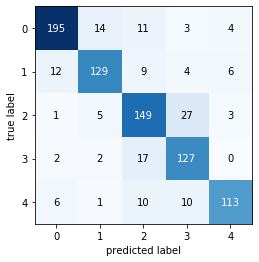

In [48]:
cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm);

### Modify to be able to take augmentied data.

A model of the same convolutional base as previously used i.e. InceptionV3, followed by the previously trained MLP.

In [ ]:
conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))

model5 = models.Sequential()
model5.add(conv_base)
model5.add(layers.Flatten())
model5.add(model4) #Last 2 layers from previous model that had an accuracy of ~0.8 on test set

model5.summary()

We make a prediction on the test data to see that the accuracy corresponds to the one we previously had.

In [ ]:
y_hat = model5.predict_generator(test_generator)
y_pred = np.argmax(y_hat, axis = 1)
y = test_generator.classes

We see that we have the same accuracy as for the previous model that was not able to take in augmented data.

In [ ]:
print('Accuracy :', accuracy_score(y,y_pred))
print('Confusion Matrix :\n', confusion_matrix(y, y_pred))

See the numer of trainable weigt vectors.

In [ ]:
len(model5.trainable_weights)

In [ ]:
conv_base.trainable = False

See the numer of trainable weigt vectors. Should be the wights + bias of the last 2 layers = 4 total.

In [ ]:
len(model5.trainable_weights)

We augment the data used for training.

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)


val_datagen = ImageDataGenerator(rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)

Same precedure as before...

In [ ]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (150,150),
                                                    batch_size = 20,
                                                    classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                                    class_mode = 'categorical')
validation_generator = val_datagen.flow_from_directory(validation_dir,
                                                       target_size = (150,150),
                                                       batch_size = 20,
                                                       classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                                       class_mode = 'categorical')
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  shuffle = False,
                                                  target_size = (150,150),
                                                  batch_size = 20,
                                                  classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                                  class_mode = 'categorical')

In [ ]:
model5.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

Train the model, same as before...

In [ ]:
if retrain_model:
    history = model5.fit_generator(train_generator,
                                   steps_per_epoch = 129,
                                   epochs = 30, 
                                   validation_data = validation_generator,
                                   validation_steps = 43)

Plot the training process... 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validaion accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validaion loss')
plt.legend()

plt.show()

The validation loss is not behaving as we expect!

In [ ]:
y_hat = model5.predict_generator(test_generator)
y_pred = np.argmax(y_hat, axis = 1)
y = test_generator.classes

And the predictions on the test set got worse!

In [ ]:
print('Accuracy :', accuracy_score(y,y_pred))
print('Confusion Matrix :\n', confusion_matrix(y, y_pred))

In [ ]:
cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm);

What is up here?